

**Block 1: Create Synthetic Store Sales data.** RUN ME FIRST
* This script generates a realistic synthetic retail dataset with 1,000 records featuring store operations, marketing, and sales data.

In [1]:
# --- Install dependencies (Colab usually has these preinstalled) ---
!pip install torch pandas numpy

# --- Imports ---
import torch, pandas as pd, numpy as np

# For reproducibility
torch.manual_seed(42)

N = 1000  # number of rows

# --- Basic categorical fields ---
store_ids_all = torch.arange(101, 151)  # store IDs 101–150
regions = ["East", "West", "North", "South"]
seasons = ["Winter", "Spring", "Summer", "Fall"]
discount_choices = torch.tensor([0.00, 0.05, 0.10, 0.15, 0.20])

# Fixed store-to-region mapping
store_to_region = {
    int(s.item()): regions[int(torch.randint(0, len(regions), (1,)).item())]
    for s in store_ids_all
}

# --- Sample fields ---
store_id = store_ids_all[torch.randint(0, len(store_ids_all), (N,))].numpy()
region_series = [store_to_region[int(s)] for s in store_id]
day_of_week = torch.randint(1, 8, (N,))  # 1..7

# Season with slight bias toward Spring/Summer
season_idx = torch.multinomial(torch.tensor([0.22, 0.28, 0.28, 0.22]), N, replacement=True)
season_series = [seasons[int(i)] for i in season_idx]

# Competitor price with region-based shift
base_price = 12.2
region_price_shift = {"East": 0.30, "West": -0.10, "North": 0.00, "South": 0.15}
comp_price = torch.empty(N)
for i in range(N):
    r = region_series[i]
    comp_price[i] = base_price + region_price_shift[r] + 0.6*torch.randn(1)
comp_price = torch.clamp(comp_price, 10.49, 14.99)

# Discount rate with seasonal weighting
season_discount_weight = {
    "Winter": torch.tensor([0.15, 0.30, 0.25, 0.20, 0.10]),
    "Spring": torch.tensor([0.25, 0.30, 0.25, 0.15, 0.05]),
    "Summer": torch.tensor([0.35, 0.30, 0.20, 0.10, 0.05]),
    "Fall":   torch.tensor([0.20, 0.30, 0.25, 0.15, 0.10])
}
discount_rate = torch.empty(N)
for i in range(N):
    w = season_discount_weight[season_series[i]]
    idx = torch.multinomial(w, 1).item()
    discount_rate[i] = discount_choices[idx]

# --- Marketing spend ---
season_marketing_shift = {"Winter": -200, "Spring": 200, "Summer": 100, "Fall": 0}
dow_shift = (day_of_week >= 6).float() * 200  # weekend boost
marketing_spend = (
    1500
    + torch.randn(N)*600
    + torch.tensor([season_marketing_shift[s] for s in season_series])
    + dow_shift
)
marketing_spend = marketing_spend.clamp(200, 5000).round()

# --- Foot traffic ---
season_traffic_shift = {"Winter": -30, "Spring": 30, "Summer": 15, "Fall": 0}
dow_traffic_boost = (day_of_week >= 6).float() * 25
traffic = (
    80
    + 0.05*marketing_spend
    + torch.tensor([season_traffic_shift[s] for s in season_series])
    + dow_traffic_boost
    + 8*(comp_price - 12)
    + torch.randn(N)*20
)
foot_traffic = traffic.clamp(60, 600).round()

# --- Sales ---
season_sales_shift = {"Winter": -200, "Spring": 300, "Summer": 100, "Fall": 0}
sales = (
    8*foot_traffic
    + 1.8*marketing_spend
    + 180*(comp_price - 12)
    + 2500*discount_rate
    + torch.tensor([season_sales_shift[s] for s in season_series])
    + torch.randn(N)*500
)
sales = sales.clamp(1200, 20000).round()

# --- Build DataFrame ---
df = pd.DataFrame({
    "Store ID": store_id,
    "Region": region_series,
    "Day Of Week": day_of_week.int().numpy(),
    "Marketing Spend": marketing_spend.int().numpy(),
    "Foot Traffic": foot_traffic.int().numpy(),
    "Competitor Price": comp_price.round().numpy(),
    "Discount Rate": discount_rate.round().numpy(),
    "Season": season_series,
    "Sales": sales.int().numpy()
})

# Save to CSV
df.to_csv("synthetic_store_sales_1000.csv", index=False)
print("✅ Dataset created and saved as synthetic_store_sales_1000.csv")

# Show preview
df.head()


✅ Dataset created and saved as synthetic_store_sales_1000.csv


,Store ID,Region,Day Of Week,Marketing Spend,Foot Traffic,Competitor Price,Discount Rate,Season,Sales
0,121,West,7,535,110,12.0,0.0,Winter,1316
1,110,West,2,1830,186,11.0,0.0,Spring,5373
2,121,West,3,883,112,12.0,0.0,Summer,2571
3,140,North,4,841,180,12.0,0.0,Summer,2424
4,137,South,3,1202,171,12.0,0.0,Summer,4028


**Block 2: Neural Network** - Make sure to run the block of code above before running code below.

---



1316.0
Epoch 100 | Train MAE=$456.3307 | Test MAE=$417.788 | R²=0.881
Epoch 200 | Train MAE=$427.1953 | Test MAE=$399.500 | R²=0.887
Epoch 300 | Train MAE=$426.0819 | Test MAE=$400.803 | R²=0.886
Epoch 400 | Train MAE=$425.7502 | Test MAE=$401.351 | R²=0.886
Epoch 500 | Train MAE=$426.4802 | Test MAE=$401.026 | R²=0.886

Final Test MAE: $401.026 | R²: 0.886


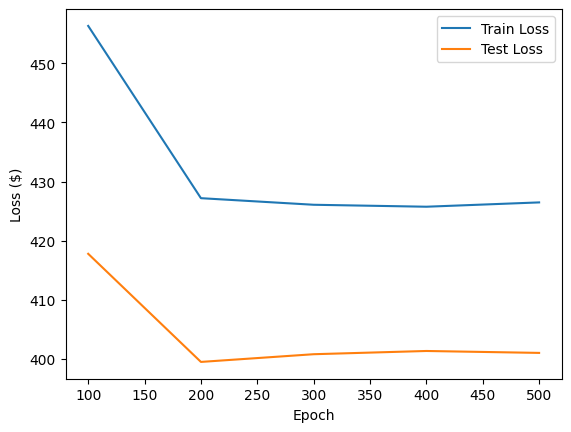

In [2]:

import numpy as np, pandas as pd, torch, torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# --- config ---
CSV_PATH   = "synthetic_store_sales_1000.csv"
TARGET_COL = "Sales"
EPOCHS = 500
PRINT_EVERY = 100
LR = 0.01
HIDDEN = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- load & split ---
df = pd.read_csv(CSV_PATH).dropna(subset=[TARGET_COL])
y  = df[TARGET_COL].values.astype(np.float32)
X  = df.drop(columns=[TARGET_COL]).select_dtypes(include=[np.number]).values.astype(np.float32)

# import train_test_split from sklearn.model_selection and split the data 80% training 20% testing.
X_train_np, X_test_np, y_train_np, y_test_np = __

# --- scale 0–1 ---
scaler = MinMaxScaler().fit(X_train_np)
Xtr = scaler.transform(X_train_np)
Xte = scaler.transform(X_test_np)

print(y[0])
# --- tensors ---
X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_np, dtype=torch.float32).view(-1,1).to(device)

# make X_test and y_test to be tensor
X_test = _
y_test= _

# --- simple MLP ---
class RegressionModel(nn.Module):
    def __init__(self, in_dims, out_dims, hidden_dims):
        super(RegressionModel, self).__init__()
        self.layers = nn.Sequential(
          nn.Linear(in_dims, hidden_dims),
          nn.ReLU(),
          nn.Linear(hidden_dims, hidden_dims),
          nn.ReLU(),
          nn.Linear(hidden_dims, out_dims)
        )

    def forward(self, x):
        return self.layers(x)

in_dims = Xtr.shape[1]
model = RegressionModel(in_dims, 1, HIDDEN).to(device)

# use L1Loss for the loss function
loss_fn = _

# add the model parameters to optimizer
opt  = torch.optim.Adam(_, lr=LR)

train_loss = []
test_loss = []
epoch_count = []

# --- train loop ---
for epoch in range(1, EPOCHS+1):
    model.train()
    preds = model(Xtr)
    # finish the loss function
    loss = loss_fn(preds, __)

    opt.zero_grad()
    loss.backward()
    opt.step()

    model.eval()
    with torch.inference_mode():
        test_preds = model(X_test)
        # complete loss function
        test_t_loss = loss_fn(test_preds, __)
        mae = mean_absolute_error(y_test.cpu().numpy(), test_preds.cpu().numpy())
        r2 = r2_score(y_test.cpu().numpy(), test_preds.cpu().numpy())

        if epoch % PRINT_EVERY == 0:
            print(f"Epoch {epoch:3d} | Train MAE=${loss.item():.4f} | Test MAE=${mae:.3f} | R²={r2:.3f}")

            train_loss.append(loss.item())
            test_loss.append(test_t_loss.item())
            epoch_count.append(epoch)

# --- final eval ---
with torch.inference_mode():
    y_pred = model(Xte).cpu().numpy().ravel()
mae = mean_absolute_error(y_test.cpu().numpy(), y_pred)
r2   = r2_score(y_test.cpu().numpy(), y_pred)
print(f"\nFinal Test MAE: ${mae:.3f} | R²: {r2:.3f}")

plt.plot(epoch_count, train_loss, label='Train Loss')
plt.plot(epoch_count, test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss ($)')
plt.legend()
plt.show()

